## HW-3 Naive Bayes Classification
Bryan Zhao, 24-787:B

Import all the package you need to use:

In [190]:
import glob # for finding file names
import numpy as np
import scipy.io as sio # to save dictionaries, don't have to compute every time
import re # regular expressions for splitting
import math # for log
import matplotlib.pyplot as plt # visualization

Define a function to get the file list for each type of data from dataset:

In [4]:
def get_filelist():
    neg_files_train = glob.glob('./hw2_dataset_nb/train/neg/*.txt')
    pos_files_train = glob.glob('./hw2_dataset_nb/train/pos/*.txt')
    neg_files_test = glob.glob('./hw2_dataset_nb/test/neg/*.txt')
    pos_files_test = glob.glob('./hw2_dataset_nb/test/pos/*.txt')
    return neg_files_train, pos_files_train, neg_files_test, pos_files_test

Define a function to read all the files for each category of training data:

In [6]:
def build_vocabulary(filelist):
    dictionary = {} # initialization
    for file in filelist: # loop through all files of the provided list
        fh = open(file)
        for file_line in fh:
            words = re.split('[, \-!?:]', file_line) # parse through all words, split by whitespaces and punctuation
            for word in words:
                if word.lower() in dictionary:
                    dictionary[word.lower()] += 1 # increment number of times the existing word is seen
                else:
                    dictionary[word.lower()] = 1
        fh.close() # close file
    return dictionary

Build the dictionaries for positive and negative datasets (if dictionaries have not yet been built)

In [213]:
neg_files_train, pos_files_train, neg_files_test, pos_files_test = get_filelist() # obtain list of filenames
dict_neg_train = build_vocabulary(neg_files_train) # build vocabularies for each dataset
dict_pos_train = build_vocabulary(pos_files_train)

In [15]:
total_pos_words = sum(dict_pos_train.values())
total_neg_words = sum(dict_neg_train.values())
print('In positive trained dictionary, there are {} words.'.format(total_pos_words))
print('In negative trained dictionary, there are {} words.'.format(total_neg_words))

In positive trained dictionary, there are 3381232 words.
In negative trained dictionary, there are 3311718 words.


Define a function to calculate the Bayes product:

In [ ]:
# Function to find unique total number of words between 2 dictionaries
def unique_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    unique_num = np.sum(list(z.values())) # number of unique words in merged dictionary
    return unique_num

In [148]:
def calculate_bayes(file, total_pos, total_neg, alpha):
    unique_numwords = unique_two_dicts(dict_pos_train, dict_neg_train) # union of both dicts
    # calculate bayes product for negative class
    file_words_neg = {} # init dictionary
    fh_neg = open(file)
    freq_in_file_neg = [] # initialize array of frequencies of each word occurrence in dictionary
    for line in fh_neg:
        words = re.split('[, \-!?:]', line) # parse through all words, split by whitespaces and punctuation
        for word in words:
            if word.lower() in dict_neg_train:
                freq_in_file_neg.append(dict_neg_train[word.lower()] + alpha) # increment number of times the existing word is seen
            else:
                freq_in_file_neg.append(alpha) # implement laplace smoothing
                
    # compute log-likelihood of P(X|Y)P(Y), with laplace smoothing for frequencies            
    bayes_product_neg = np.sum(np.log(freq_in_file_neg/(total_neg + alpha*unique_numwords))) + np.log(0.5)
    fh_neg.close()
    
    # calculate bayes product for positive class
    file_words_pos = {} # init dictionary
    fh_pos = open(file)
    freq_in_file_pos = []
    for line in fh_pos:
        words = re.split('[, \-!?:]', line)
        for word in words:
            if word.lower() in dict_pos_train:
                freq_in_file_pos.append(dict_pos_train[word.lower()] + alpha) # increment number of times the existing word is seen
            else:
                freq_in_file_pos.append(alpha) # implement laplace smoothing
                
    # compute log-likelihood of P(X|Y)P(Y), with laplace smoothing    
    bayes_product_pos = np.sum(np.log(freq_in_file_pos/(total_pos + alpha*unique_numwords))) + np.log(0.5)
    fh_pos.close()
    return bayes_product_pos, bayes_product_neg

Define a function to test the naive bayes classifier:

In [150]:
def test_naivebayes(files, total_pos_words, total_neg_words, alpha):
    bayes_result = [] # initialize classification array (0's or 1's)
    
    # loop through all files, and calculate bayes product for positive and negative dictionaries
    for file in files:
        bayes_product_pos, bayes_product_neg = calculate_bayes(file, total_pos_words, total_neg_words, alpha)
        bayes_result.append((bayes_product_pos > bayes_product_neg).astype(int)) # returns 1 for positive, 0 for negative
    return bayes_result

Initialize the alpha, get the whole data list for different types of data, read and save all the data from dataset, then find the positive accuracy and negative accuracy:

In [196]:
alpha = 1 # for laplacian smoothing
bayes_result_pos = test_naivebayes(pos_files_test, total_pos_words, total_neg_words, alpha)
bayes_result_neg = test_naivebayes(neg_files_test, total_pos_words, total_neg_words, alpha)
num_pos_files = len(pos_files_test) # should be 12,500 per class
num_neg_files = len(neg_files_test)

Print accuracy results and confusion matrix results:

In [197]:
# print results
alpha = 1
print('Positive accuracy with Laplacian smoothing and alpha = {}:'.format(alpha), sum(bayes_result_pos)/num_pos_files)
print('Negative accuracy with Laplacian smoothing and alpha = {}:'.format(alpha), 1 - sum(bayes_result_neg)/num_neg_files)

num_classified_positive = sum(bayes_result_pos)
num_classified_negative = num_neg_files - sum(bayes_result_neg)

# populate confusion matrix with true positives, false positives, true negatives, false negatives
confusion_matrix = np.array([[num_classified_negative, sum(bayes_result_neg)], \
                             [num_pos_files - num_classified_positive, num_classified_positive]])
print('\nConfusion matrix:\n', confusion_matrix)
print('--------------')
print('TN, FP')
print('FN, TP')

Positive accuracy with Laplacian smoothing and alpha = 1: 0.7968
Negative accuracy with Laplacian smoothing and alpha = 1: 0.84792

Confusion matrix:
 [[10599  1901]
 [ 2540  9960]]
--------------
TN, FP
FN, TP


In [211]:
# Part 3-e) Visualize accuracy of test dataset for related values of alpha

# Note: this for some reason was faster than a loop implementation for plotting, from trial 
# error (otherwise, would have utilized a for loop to plot the results)
factor = 10
alpha1 = 0.0001
alpha2 = alpha1*factor
alpha3 = alpha2*factor
alpha4 = alpha3*factor
alpha5 = alpha4*factor
alpha6 = alpha5*factor
alpha7 = alpha6*factor
alpha8 = alpha7*factor

# calculate naive bayes result for every alpha
bayes_result1_pos = test_naivebayes(pos_files_test, total_pos_words, total_neg_words, alpha1)
bayes_result2_pos = test_naivebayes(pos_files_test, total_pos_words, total_neg_words, alpha2)
bayes_result3_pos = test_naivebayes(pos_files_test, total_pos_words, total_neg_words, alpha3)
bayes_result4_pos = test_naivebayes(pos_files_test, total_pos_words, total_neg_words, alpha4)
bayes_result5_pos = test_naivebayes(pos_files_test, total_pos_words, total_neg_words, alpha5)
bayes_result6_pos = test_naivebayes(pos_files_test, total_pos_words, total_neg_words, alpha6)
bayes_result7_pos = test_naivebayes(pos_files_test, total_pos_words, total_neg_words, alpha7)
bayes_result8_pos = test_naivebayes(pos_files_test, total_pos_words, total_neg_words, alpha8)

# now, find accuracy of each result
acc1 = sum(bayes_result1_pos)/num_pos_files
acc2 = sum(bayes_result2_pos)/num_pos_files
acc3 = sum(bayes_result3_pos)/num_pos_files
acc4 = sum(bayes_result4_pos)/num_pos_files
acc5 = sum(bayes_result5_pos)/num_pos_files
acc6 = sum(bayes_result6_pos)/num_pos_files
acc7 = sum(bayes_result7_pos)/num_pos_files
acc8 = sum(bayes_result8_pos)/num_pos_files

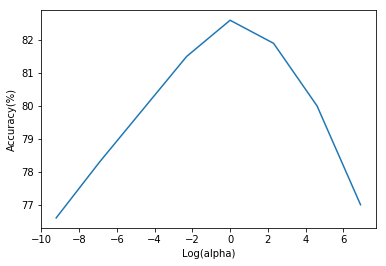

In [209]:
# Visualize alpha vs accuracies on a log x-scale and accuracies on y-scale
plt.plot(np.log(alpha1), acc1)
plt.plot(np.log(alpha2), acc2)
plt.plot(np.log(alpha3), acc3)
plt.plot(np.log(alpha4), acc4)
plt.plot(np.log(alpha5), acc5)
plt.plot(np.log(alpha6), acc6)
plt.plot(np.log(alpha7), acc7)
plt.plot(np.log(alpha8), acc8)

Why do you consider the accuracy be affected when α is too high or too low?

We start with the probability of $P(word | class)$ as $\frac{F + \alpha}{T + \alpha*U}$ (as mentioned in the Piazza post), where F is the frequency of a word, $\alpha$ is the laplace (or additive) smoothing factor, T is the total number of words in **either** the positive or negative dictionary, and U is the number of unique words between both dictionaries. 

When $\alpha$ is too high, there is too much of a smoothing factor, so in essence, any words with a smaller frequency are filtered out of the Bayes product and have too small of a weight. This leads to most words (especially those with a lower frequency) having a similar individual probability. Subsequently, finer details of the dictionary (words with smaller frequences) are not captured in the classification model. When $\alpha$ is too small, there is virtually no smoothing factor, so new words do not have much of an affect on the classification model, leading to a less accurate result.

In [ ]:
# end of HW2-3